In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/f1/sjzn52hj01g7nqn5c6rs02180000gp/T/ipykernel_39037/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.

most_recent_date = session.query(func.max(Measurement.date)).scalar()

most_recent_date


'2017-08-23'

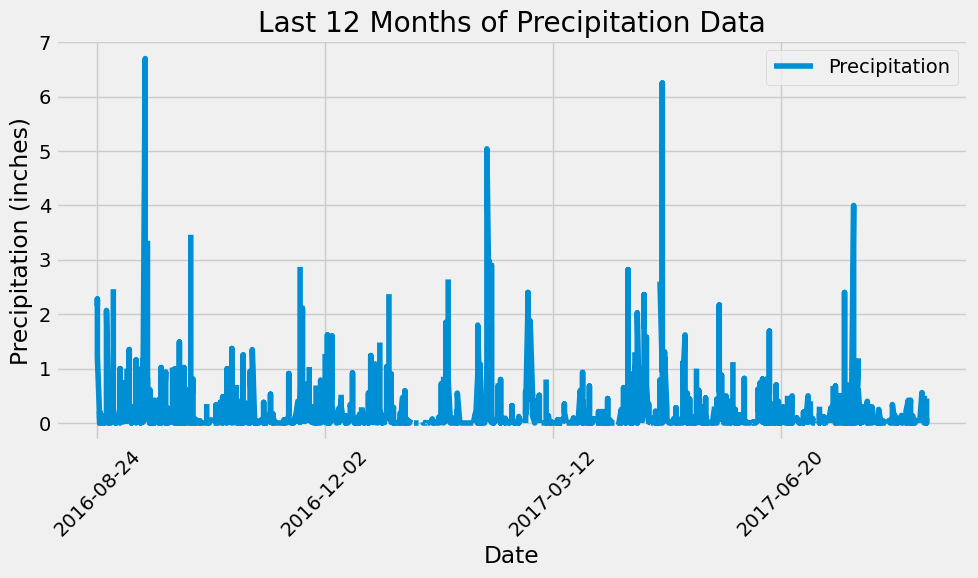

In [20]:
# Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
last_year_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= last_year_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_data['Date'], precipitation_data['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))  # Set maximum number of ticks to 4
plt.tight_layout()
plt.legend()
plt.show()


In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_data['Precipitation'].describe()

print(summary_statistics)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations in the dataset:", total_stations)


Total number of stations in the dataset: 9


In [36]:
from sqlalchemy import desc  # Don't forget to import desc

# Design a query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(desc(func.count(Measurement.station))).all()

# List the stations and their counts in descending order
for station, count in active_stations:
    print(f"Station ID: {station}, Total Rows: {count}")

Station ID: USC00519281, Total Rows: 2772
Station ID: USC00519397, Total Rows: 2724
Station ID: USC00513117, Total Rows: 2709
Station ID: USC00519523, Total Rows: 2669
Station ID: USC00516128, Total Rows: 2612
Station ID: USC00514830, Total Rows: 2202
Station ID: USC00511918, Total Rows: 1979
Station ID: USC00517948, Total Rows: 1372
Station ID: USC00518838, Total Rows: 511


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the most active station ID from the previous query
most_active_station = active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
                     filter(Measurement.station == most_active_station).all()

print(temperature_stats)


[(54.0, 85.0, 71.66378066378067)]


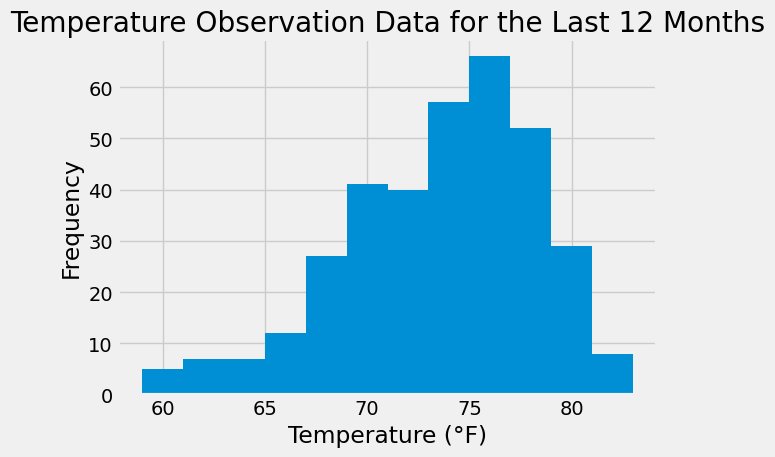

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Design a query to retrieve the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
                   filter(Measurement.station == most_active_station).\
                   filter(Measurement.date >= last_year_date).all()

# Extract temperatures from the result
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Last 12 Months')
plt.tight_layout()
plt.show()


# Close Session

In [40]:
# Close Session
session.close()